In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features...
Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



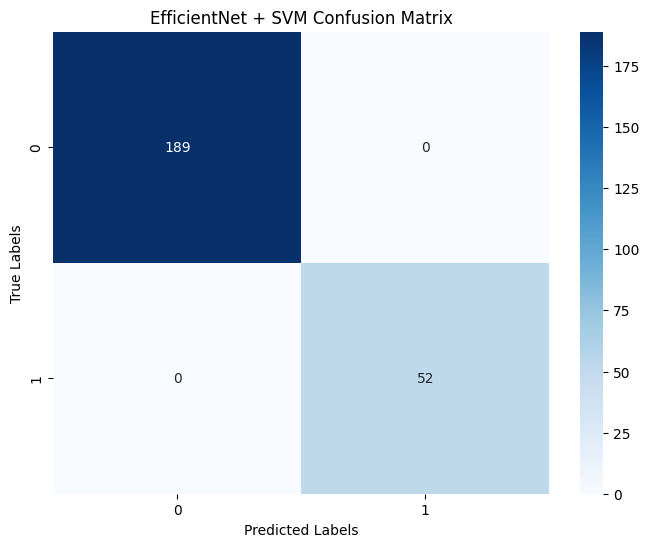

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):  # Increased batch size
    transform = transforms.Compose([
        transforms.Resize((227, 227)),  # Fixed size 227x227
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1024) # increased feature size
    model.avgpool = nn.AdaptiveAvgPool2d(1) #added adaptive pooling
    model = nn.Sequential(model, nn.Flatten(1)) #flatten the output

    model = model.to(device)

    # Extract features using EfficientNet
    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    val_features, val_labels = extract_features(model, val_loader)
    test_features, test_labels = extract_features(model, test_loader)

    # Train SVM classifier
    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)  # You can adjust kernel and C
    svm_classifier.fit(train_features, train_labels)

    # Evaluate SVM classifier
    print("Evaluating SVM classifier...")
    evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Extracting features...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241



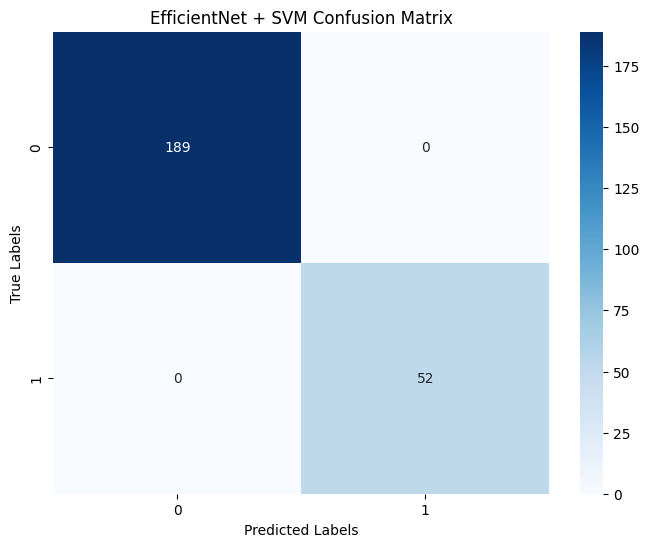

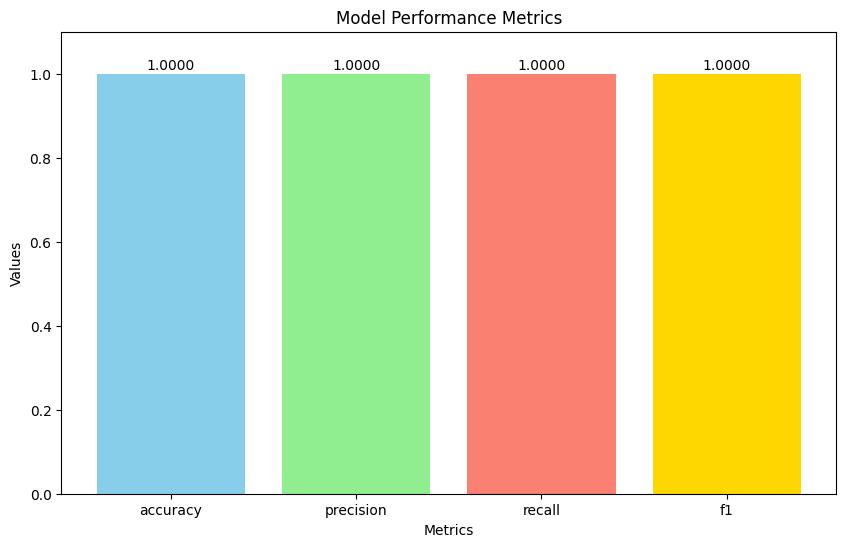

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1024)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model = nn.Sequential(model, nn.Flatten(1))

    model = model.to(device)

    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    val_features, val_labels = extract_features(model, val_loader)
    test_features, test_labels = extract_features(model, test_loader)

    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)
    svm_classifier.fit(train_features, train_labels)

    print("Evaluating SVM classifier...")
    results = evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

    # Plotting Results
    plot_results(results)

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)  # Set y-axis limit for better visualization
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Add value labels
    plt.show()

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Training EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3563159770435757
Epoch 1/10, Validation Loss: 0.34090206027030945
Epoch 2/10, Loss: 0.07236092330680953
Epoch 2/10, Validation Loss: 0.017659847158938646
Epoch 3/10, Loss: 0.02667210018262267
Epoch 3/10, Validation Loss: 0.008968398440629244
Epoch 4/10, Loss: 0.014613242690554924
Epoch 4/10, Validation Loss: 0.002570042386651039
Epoch 5/10, Loss: 0.013640647508307464
Epoch 5/10, Validation Loss: 0.0026693687541410327
Epoch 6/10, Loss: 0.007856603065091703
Epoch 6/10, Validation Loss: 0.002374734031036496
Epoch 7/10, Loss: 0.004887112726767858
Epoch 7/10, Validation Loss: 0.0015910299262031913
Epoch 8/10, Loss: 0.0035702020718923044
Epoch 8/10, Validation Loss: 0.0013101334334351122
Epoch 9/10, Loss: 0.004736933507956564
Epoch 9/10, Validation Loss: 0.0018029137281700969
Epoch 10/10, Loss: 0.0022856141893296605
Epoch 10/10, Validation Loss: 0.00129181076772511
Extracting features...
Training SVM classifier...
Evaluating SVM classifier...
EfficientNet + SVM Evaluation

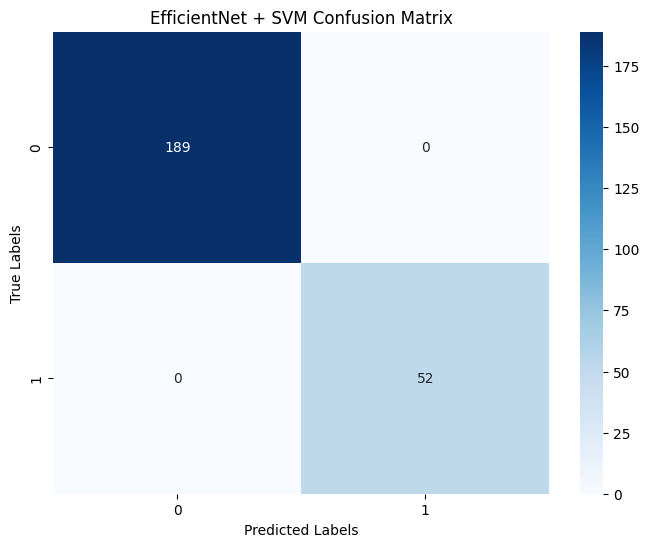

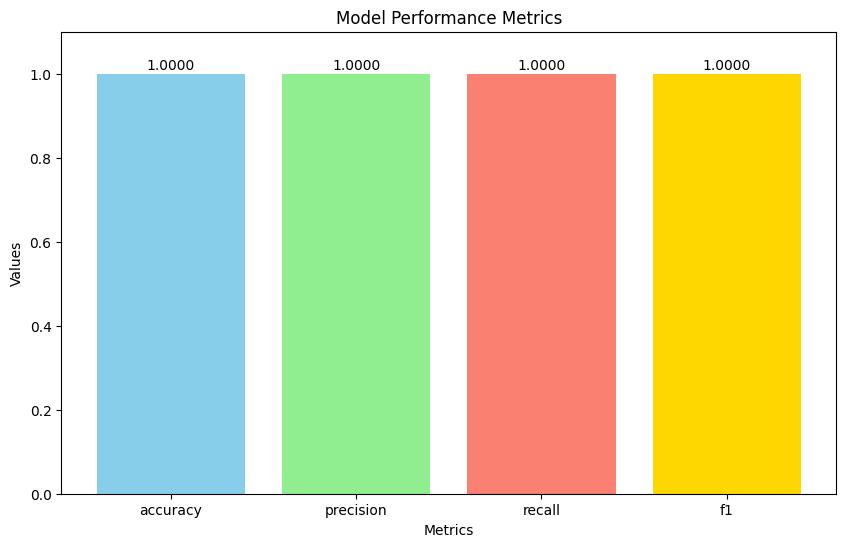

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def evaluate_classifier_and_plot_confusion_matrix(classifier, features, labels, model_name):
    predictions = classifier.predict(features)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    print(f"{model_name} Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def train_efficientnet(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}")

    return model

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
    model = model.to(device)

    print("Training EfficientNet model...")
    model = train_efficientnet(model, train_loader, val_loader)

    print("Extracting features...")
    train_features, train_labels = extract_features(model, train_loader)
    test_features, test_labels = extract_features(model, test_loader)

    print("Training SVM classifier...")
    svm_classifier = SVC(kernel='rbf', C=1)
    svm_classifier.fit(train_features, train_labels)

    print("Evaluating SVM classifier...")
    results = evaluate_classifier_and_plot_confusion_matrix(svm_classifier, test_features, test_labels, "EfficientNet + SVM")

    # Plotting Results
    plot_results(results)

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda
Loading data...
Loading EfficientNet model...
Training EfficientNet model...


c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.27104737816585434
Epoch 1/10, Validation Loss: 0.23730351775884628
Epoch 2/10, Loss: 0.052567401693926916
Epoch 2/10, Validation Loss: 0.010004077106714249
Epoch 3/10, Loss: 0.024717777320701215
Epoch 3/10, Validation Loss: 0.004444626159965992
Epoch 4/10, Loss: 0.00839455609416796
Epoch 4/10, Validation Loss: 0.0031072708079591393
Epoch 5/10, Loss: 0.008639105518038074
Epoch 5/10, Validation Loss: 0.0026198718696832657
Epoch 6/10, Loss: 0.006644823497885631
Epoch 6/10, Validation Loss: 0.0016485889791511
Epoch 7/10, Loss: 0.003862155905355596
Epoch 7/10, Validation Loss: 0.0012116602738387883
Epoch 8/10, Loss: 0.0031000740483351466
Epoch 8/10, Validation Loss: 0.0010298487322870642
Epoch 9/10, Loss: 0.003070995179263668
Epoch 9/10, Validation Loss: 0.0010959072969853878
Epoch 10/10, Loss: 0.0024558900590313393
Epoch 10/10, Validation Loss: 0.0007530788134317845
Evaluating EfficientNet model...
EfficientNet Evaluation:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall

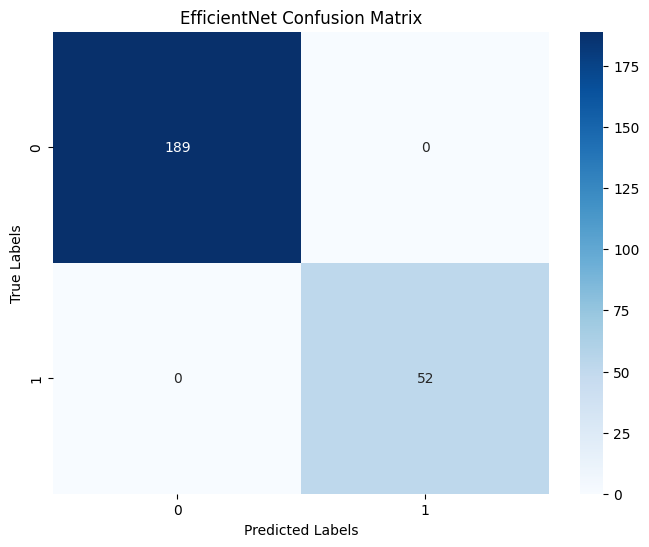

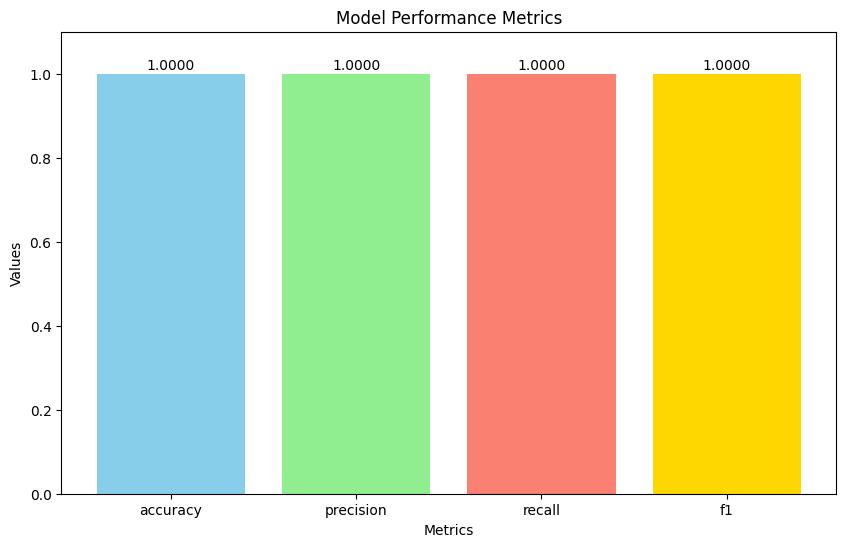

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check if CUDA (GPU) is available
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU found")

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

def train_efficientnet(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_loader)}")

    return model

def evaluate_efficientnet(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("EfficientNet Evaluation:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('EfficientNet Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

def plot_results(results):
    metrics = list(results.keys())
    values = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
    plt.title('Model Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.ylim(0, 1.1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.show()

def main(data_dir):
    print("Loading data...")
    train_loader, val_loader, test_loader = load_data(data_dir)

    print("Loading EfficientNet model...")
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
    model = model.to(device)

    print("Training EfficientNet model...")
    model = train_efficientnet(model, train_loader, val_loader)

    print("Evaluating EfficientNet model...")
    results = evaluate_efficientnet(model, test_loader)

    # Plotting Results
    plot_results(results)

if __name__ == "__main__":
    data_directory = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"
    main(data_directory)

In [ ]:
##breaking the code down


In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227): #Added image_size parameter
    """Loads data, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)), # Added resize transform
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
# for images, labels in train_loader:
#     print("Image batch shape:", images.shape)
#     print("Label batch shape:", labels.shape)
#     break

# Example to check the first label batch.
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch:", labels)
    break

Image batch shape: torch.Size([32, 3, 227, 227])
Label batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0])


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import numpy as np

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227):
    """Loads data with preprocessing, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),  # Convert to grayscale
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),  # Smoothen
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),  # Contrast stretching
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import numpy as np

# Define your data directory
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=227):
    """Loads data with preprocessing, returning DataLoaders."""

    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),  # Convert to grayscale
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),  # Smoothen
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),  # Contrast stretching
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

# Load data
train_loader, val_loader, test_loader = load_data(data_dir)

# Example usage (to check the data loaders)
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: torch.Size([32, 1, 227, 227])
Label batch shape: torch.Size([32])


In [11]:
import torch
import torchvision.models as models
from torchsummary import summary

# Load the EfficientNet-B0 model (you can change 'efficientnet_b0' to other variants)
model = models.efficientnet_b0(pretrained=True)

# Print a summary of the model
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model = model.to(device)

# Print the model summary
summary(model, (3, 224, 224)) # Input shape (channels, height, width)

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing (same as before)
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)

# Modify the first convolutional layer for grayscale input
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.3496, Train Acc: 94.33%, Val Loss: 0.6740, Val Acc: 71.43%
Epoch [2/10], Train Loss: 0.0768, Train Acc: 100.00%, Val Loss: 0.6088, Val Acc: 66.07%
Epoch [3/10], Train Loss: 0.0351, Train Acc: 99.65%, Val Loss: 0.2207, Val Acc: 98.21%
Epoch [4/10], Train Loss: 0.0207, Train Acc: 99.82%, Val Loss: 0.0846, Val Acc: 100.00%
Epoch [5/10], Train Loss: 0.0084, Train Acc: 100.00%, Val Loss: 0.0050, Val Acc: 100.00%
Epoch [6/10], Train Loss: 0.0099, Train Acc: 100.00%, Val Loss: 0.0023, Val Acc: 100.00%
Epoch [7/10], Train Loss: 0.0083, Train Acc: 100.00%, Val Loss: 0.0026, Val Acc: 100.00%
Epoch [8/10], Train Loss: 0.0055, Train Acc: 100.00%, Val Loss: 0.0020, Val Acc: 100.00%
Epoch [9/10], Train Loss: 0.0050, Train Acc: 100.00%, Val Loss: 0.0009, Val Acc: 100.00%
Epoch [10/10], Train Loss: 0.0038, Train Acc: 100.00%, Val Loss: 0.0007, Val Acc: 100.00%


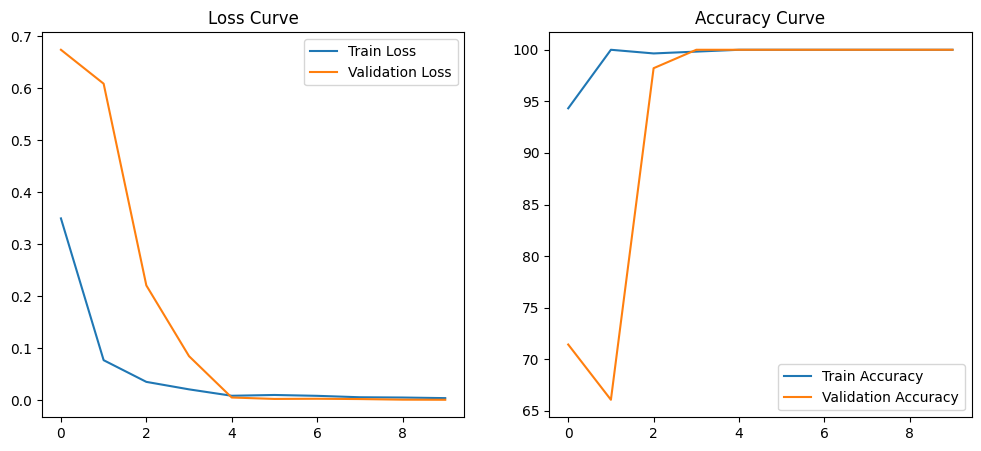

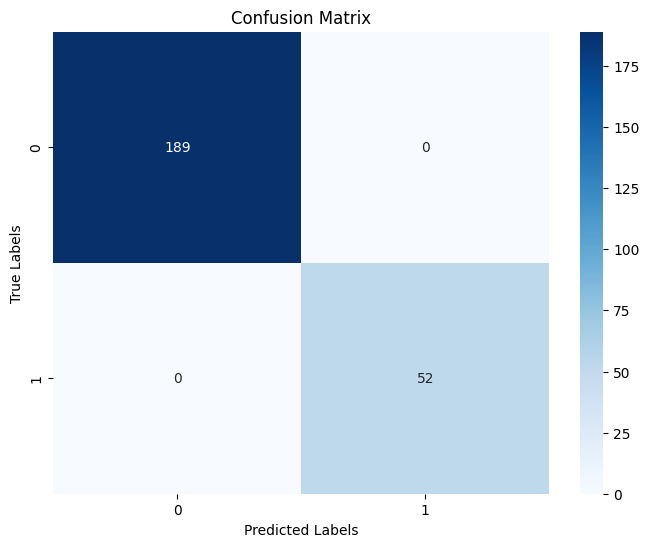

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Accuracy: 1.0


In [16]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.convert('RGB')),#convert grayscale to RGB
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")

c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\my_new_environment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 0.3594, Train Acc: 93.97%, Val Loss: 0.7035, Val Acc: 33.93%
Epoch [2/10], Train Loss: 0.0818, Train Acc: 99.47%, Val Loss: 0.5758, Val Acc: 78.57%
Epoch [3/10], Train Loss: 0.0209, Train Acc: 100.00%, Val Loss: 0.2719, Val Acc: 82.14%
Epoch [4/10], Train Loss: 0.0130, Train Acc: 100.00%, Val Loss: 0.2918, Val Acc: 78.57%
Epoch [5/10], Train Loss: 0.0167, Train Acc: 99.65%, Val Loss: 0.0444, Val Acc: 100.00%
Epoch [6/10], Train Loss: 0.0191, Train Acc: 99.47%, Val Loss: 0.0024, Val Acc: 100.00%
Epoch [7/10], Train Loss: 0.0111, Train Acc: 99.65%, Val Loss: 0.0019, Val Acc: 100.00%
Epoch [8/10], Train Loss: 0.0050, Train Acc: 100.00%, Val Loss: 0.0013, Val Acc: 100.00%
Epoch [9/10], Train Loss: 0.0045, Train Acc: 100.00%, Val Loss: 0.0016, Val Acc: 100.00%
Epoch [10/10], Train Loss: 0.0034, Train Acc: 100.00%, Val Loss: 0.0010, Val Acc: 100.00%


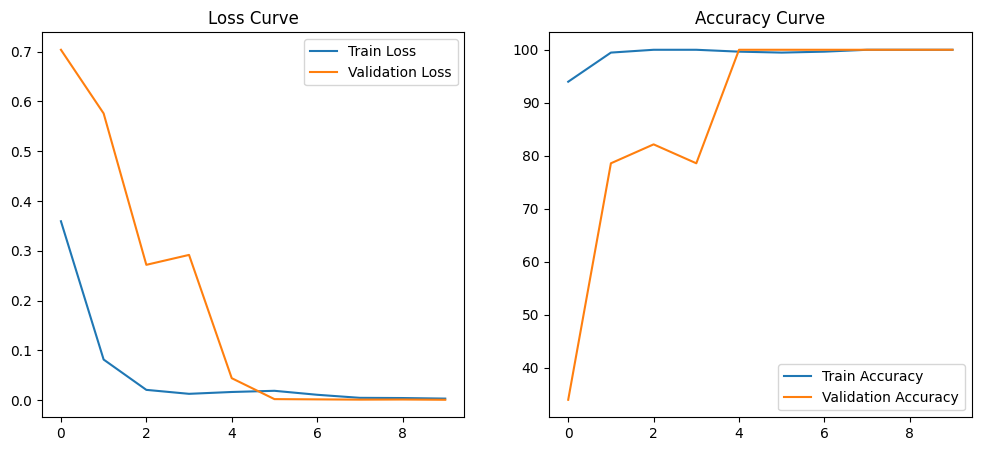

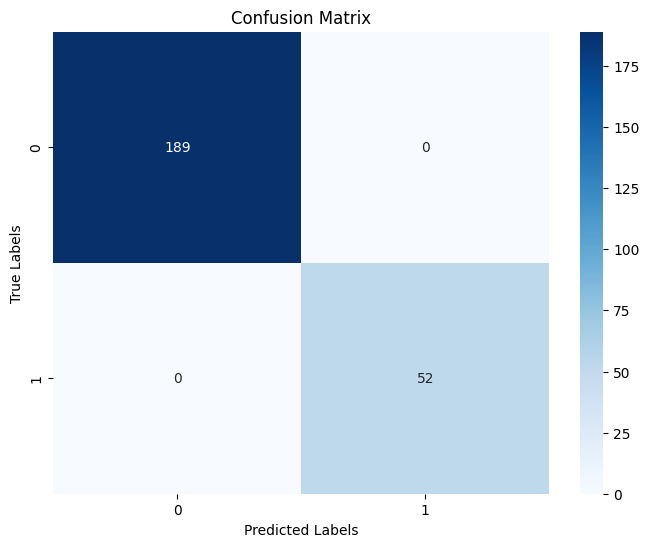

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        52

    accuracy                           1.00       241
   macro avg       1.00      1.00      1.00       241
weighted avg       1.00      1.00      1.00       241

Accuracy: 1.0


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loading and preprocessing (same as before)
data_dir = "C:/Users/chris/Downloads/sunspot classification.v1i.multiclass"

class SunspotDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_dir, batch_size=32, image_size=224):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: ImageOps.grayscale(img)),
        transforms.Lambda(lambda img: img.convert('RGB')),
        transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
        transforms.Lambda(lambda img: ImageOps.autocontrast(img)),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    train_csv = os.path.join(data_dir, "train", "_classes.csv")
    test_csv = os.path.join(data_dir, "test", "_classes.csv")
    train_img_dir = os.path.join(data_dir, "train")
    test_img_dir = os.path.join(data_dir, "test")

    train_dataset = SunspotDataset(csv_file=train_csv, img_dir=train_img_dir, transform=transform)
    test_dataset = SunspotDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    train_size = int(0.7 * len(train_dataset))
    val_size = int(0.1 * len(train_dataset))
    test_size = len(train_dataset) - train_size - val_size
    train_dataset, val_dataset, _ = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(data_dir)

# Load EfficientNet model
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Adjust output size to 2 classes
model = model.to(device)

# Loss and optimizer with regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) #L2 Regularization

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

# Evaluation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix and classification report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(classification_report(all_labels, all_preds))
print(f"Accuracy: {accuracy_score(all_labels, all_preds)}")